In [2]:
from dotenv import load_dotenv

load_dotenv(dotenv_path='/home/longview/Dev/.env')

True

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwrites them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

"Nodes represent units of work. They are typically regular python functions."

In [4]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-haiku-20240307")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called
# whenever the node is used.
graph_builder.add_node("chatbot", chatbot)


In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

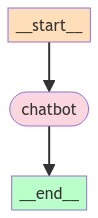

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [10]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Certainly! LangChain is a framework for building applications with large language models (LLMs) like GPT-3, Dall-E, and Anthropic's Claude. It provides a set of abstractions and tools to help developers build applications that interact with these models in a modular and scalable way.

Here are some key things to know about LangChain:

1. **Agents**: LangChain provides a way to create "agents" that can interact with LLMs to perform specific tasks. These agents can take in prompts, query databases, call APIs, and combine outputs to generate responses.

2. **Memory**: LangChain includes tools for managing the state and memory of an agent, allowing it to maintain context over multiple interactions.

3. **Chains**: LangChain allows you to build "chains" of agents that can perform multi-step tasks, passing information between them.

4. **Utilities**: LangChain includes a set of utility functions and tools for working with LLMs, such as tools for parsing and formatting text, intera

## Part 2: Enhancing the Chatbot with Tools ##

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph")

[{'url': 'https://www.nature.com/articles/s41598-024-64761-7',
  'content': 'The weight between the i-th node in the input layer and the j-th node in the hidden layer is denoted as \\({W}_{ij}\\), and the weight between the j-th node in the hidden layer and the output layer is denoted as \\({V}_{j}\\)\u200b. Here, \\({n}_{I}\\)\u200b represents the number of nodes in the input layer, and \\({n}_{H}\\)\u200b represents the number of nodes in the hidden layer. Advertisement Modeling and optimization of dyeing process of polyamide 6 and woolen fabrics with plum-tree leaves using artificial intelligence Scientific Reports volume\xa014, Article\xa0number:\xa015067 (2024) Cite this article Metrics details Subjects Abstract The dyeing process of textile materials is inherently intricate, influenced by a myriad of factors, including dye concentration, dyeing time, pH level, temperature, type of dye, fiber composition, mechanical agitation, salt concentration, mordants, fixatives, water quality

In [14]:
from langchain_community.tools import DuckDuckGoSearchResults

tool = DuckDuckGoSearchResults(num_results=2)
tools = [tool]
tool_response = tool.invoke("What's a 'node' in LangGraph")

In [30]:
tool_response

"[snippet: Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ..., title: Introduction to LangGraph: A Beginner's Guide - Medium, link: https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141], [snippet: Nodes: Nodes in LangGraph represent individual units of computation or functionality within a graph. Nodes can be functions or runnables that perform specific tasks or operations. They are ..., title: LangGraph: Multi-Agent Collaboration Explained - Medium, link: https://medium.com/@kbdhunga/langgraph-multi-agent-collaboration-explained-c0500b0f2e61]"

In [ ]:
import json

json.dumps(tool_response)

'"[snippet: Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ..., title: Introduction to LangGraph: A Beginner\'s Guide - Medium, link: https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141], [snippet: Nodes: Nodes in LangGraph represent individual units of computation or functionality within a graph. Nodes can be functions or runnables that perform specific tasks or operations. They are ..., title: LangGraph: Multi-Agent Collaboration Explained - Medium, link: https://medium.com/@kbdhunga/langgraph-multi-agent-collaboration-explained-c0500b0f2e61]"'

In [36]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm =  ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [38]:
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [39]:
from typing import Literal


def route_tools(
        state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last
    message has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The 'tools_condition' function returns "tools" if the chatbot
# asks to use a tool, and "__end__" if it is fine directly responding.
# This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret
    # the condition's outputs as a specific node.
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # you can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

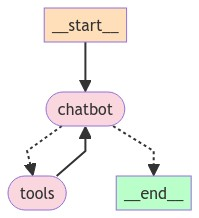

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [41]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: [{'text': "Okay, let's look up some information about Langgraph on DuckDuckGo:", 'type': 'text'}, {'id': 'toolu_011zdNZAwbxCT7A8qqbM5LY2', 'input': {'query': 'langgraph'}, 'name': 'duckduckgo_results_json', 'type': 'tool_use'}]
Assistant: "[snippet: LangGraph is a package for creating LLM workflows with cycles and multi-agent designs. Learn what multi-agent means, why it is useful, and see examples of LangGraph applications and comparisons with other frameworks., title: LangGraph: Multi-Agent Workflows, link: https://blog.langchain.dev/langgraph-multi-agent-workflows/], [snippet: LangGraph is giving us the control and ergonomics we need to build and ship powerful coding agents.\" - Michele Catasta (VP of AI @ Replit) For the most complex or sensitive tasks, human collaboration is still needed to supplement agentic automation. LangGraph makes human-agent collaboration possible through its built in persistence layer., title: Announcing LangGraph v0.1 & LangGraph Cloud: Running